In [125]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

![Screenshot 2025-11-06 at 7.29.47 AM.png](<abc.png>)

# Tidy data

In [ ]:
# Sample wide dataframe
df = pd.DataFrame({
    'Customer': ['A', 'B'],
    'Jan': [100, 90],
    'Feb': [120, 95],
    'Mar': [110, 100]
})

# Melt from wide to long
df_long = pd.melt(df, 
                  id_vars=['Customer'],      # Columns to keep as identifier
                  value_vars=['Jan','Feb','Mar'],  # Columns to unpivot
                  var_name='Month',          # Name for the new variable column
                  value_name='Sales')        # Name for the values column

print(df_long)


In [126]:
df = pd.read_csv('/Users/jialing/Pipelines/sample.csv')
df

,Customer_ID,Age,Annual_Income,Gender,City,Education,Spending_Score
0,1,36,62662,Female,C,Bachelor,58
1,2,37,73067,Male,B,Master,71
2,3,22,32454,Female,A,Diploma,59
3,4,53,118148,Male,B,Master,72
4,5,41,70965,Male,A,Master,96
...,...,...,...,...,...,...,...
95,96,22,49711,Female,A,Diploma,32
96,97,47,94584,Male,B,Master,79
97,98,25,25569,Male,B,ITE,22
98,99,27,27733,Female,B,ITE,43


In [127]:
X = df.drop(
    columns = ['Customer_ID', 'Spending_Score'],
    axis = 1
)

y = df['Spending_Score']

In [128]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Must define order for ordinal features
education_order = ['Secondary School', 'ITE', 'Diploma', 'Bachelor', 'Master']
ordinal_features = ['Education']

categorical_features = [col for col in categorical_features if col not in ordinal_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Ordinal features:", ordinal_features)

Numeric features: ['Age', 'Annual_Income']
Categorical features: ['Gender', 'City']
Ordinal features: ['Education']


In [129]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first', sparse_output = False), categorical_features),
        ('ord', OrdinalEncoder(categories=[education_order]), ordinal_features)
    ])

In [130]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), 
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='rmse')
    }

In [ ]:
# -------------------------------
# 6. Initial CV on small sample
# -------------------------------
x = 0.8
sample_frac = x  # 10% sample for initial testing
X_sample = X.sample(frac=sample_frac, random_state=42)
y_sample = y.loc[X_sample.index]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # CV RMSE
    mse_scores = cross_val_score(pipeline, X_sample, y_sample, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-mse_scores)
    
    # CV R²
    r2_scores = cross_val_score(pipeline, X_sample, y_sample, cv=kf, scoring='r2', n_jobs=-1)
    
    # Append results for this model
    cv_results.append({
        'Model': name,
        'RMSE Mean': rmse_scores.mean(),
        'R2 Mean': r2_scores.mean(),
        'RMSE Std': rmse_scores.std(),
        'R2 Std': r2_scores.std()
    })

# Create DataFrame and sort
cv_df = pd.DataFrame(cv_results).sort_values(by='RMSE Mean')
print("Initial CV Results on Sample:\n", cv_df)

# Select best model based on RMSE and R2
best_model_name = cv_df.iloc[0]['Model']
best_model = models[best_model_name]

print('-' *100)
print(f"Best model selected: {best_model_name}")

Initial CV Results on Sample:
                Model  RMSE Mean   R2 Mean  RMSE Std    R2 Std
3      Random Forest  10.188935  0.776104  1.376975  0.058933
2   Lasso Regression  10.309257  0.772116  1.043333  0.043180
1   Ridge Regression  10.437549  0.766984  1.083702  0.041649
0  Linear Regression  10.484261  0.764341  1.070364  0.044285
5            XGBoost  11.078104  0.738957  1.520702  0.052940
4  Gradient Boosting  11.607446  0.700626  0.962287  0.092330
----------------------------------------------------------------------------------------------------
Best model selected: Random Forest


## Train/test split on full dataset 

Best Model : Random Forest (Highest R2 and lowest MSE)

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fit random forest model
best_model = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', best_model)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Annual_Income']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'City']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Secondary '
                                                                              'School',
                                                                              'ITE',
                                                                              'Diploma',
                                                                              'Bachelor',
                                                                              'Master']]),
                                                  ['Education'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [137]:
# Extract feature importances
# Need to get feature names after preprocessing
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(ohe_features) + ordinal_features

importances = pipeline.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 
                                      'Importance': importances}).sort_values(by='Importance', ascending=False)
feature_importance_df


,Feature,Importance
5,Education,0.759058
1,Annual_Income,0.133537
0,Age,0.071993
3,City_B,0.014382
4,City_C,0.011153
2,Gender_Male,0.009877


/var/folders/jn/k87rrm694dq263mh4gqmfd080000gn/T/ipykernel_18128/1629936433.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


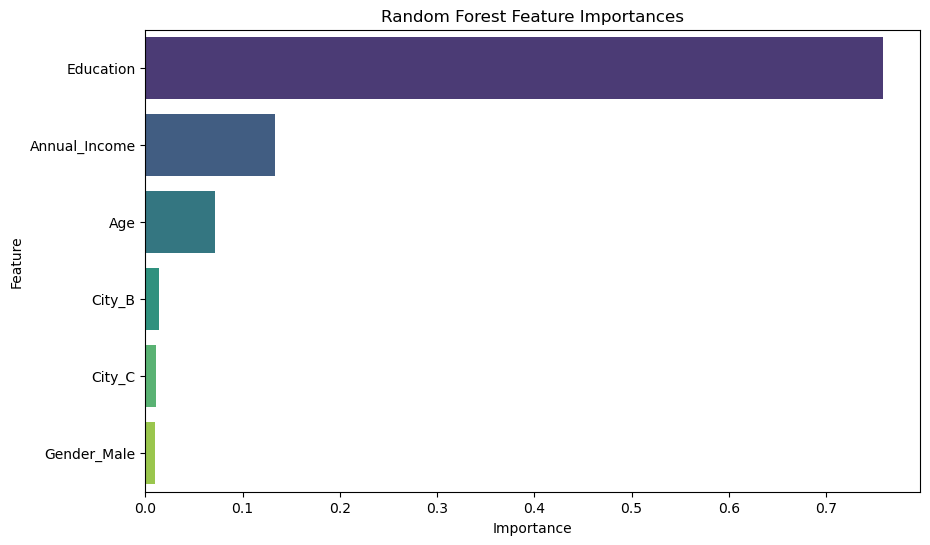

In [134]:
# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Random Forest Feature Importances")
plt.show()

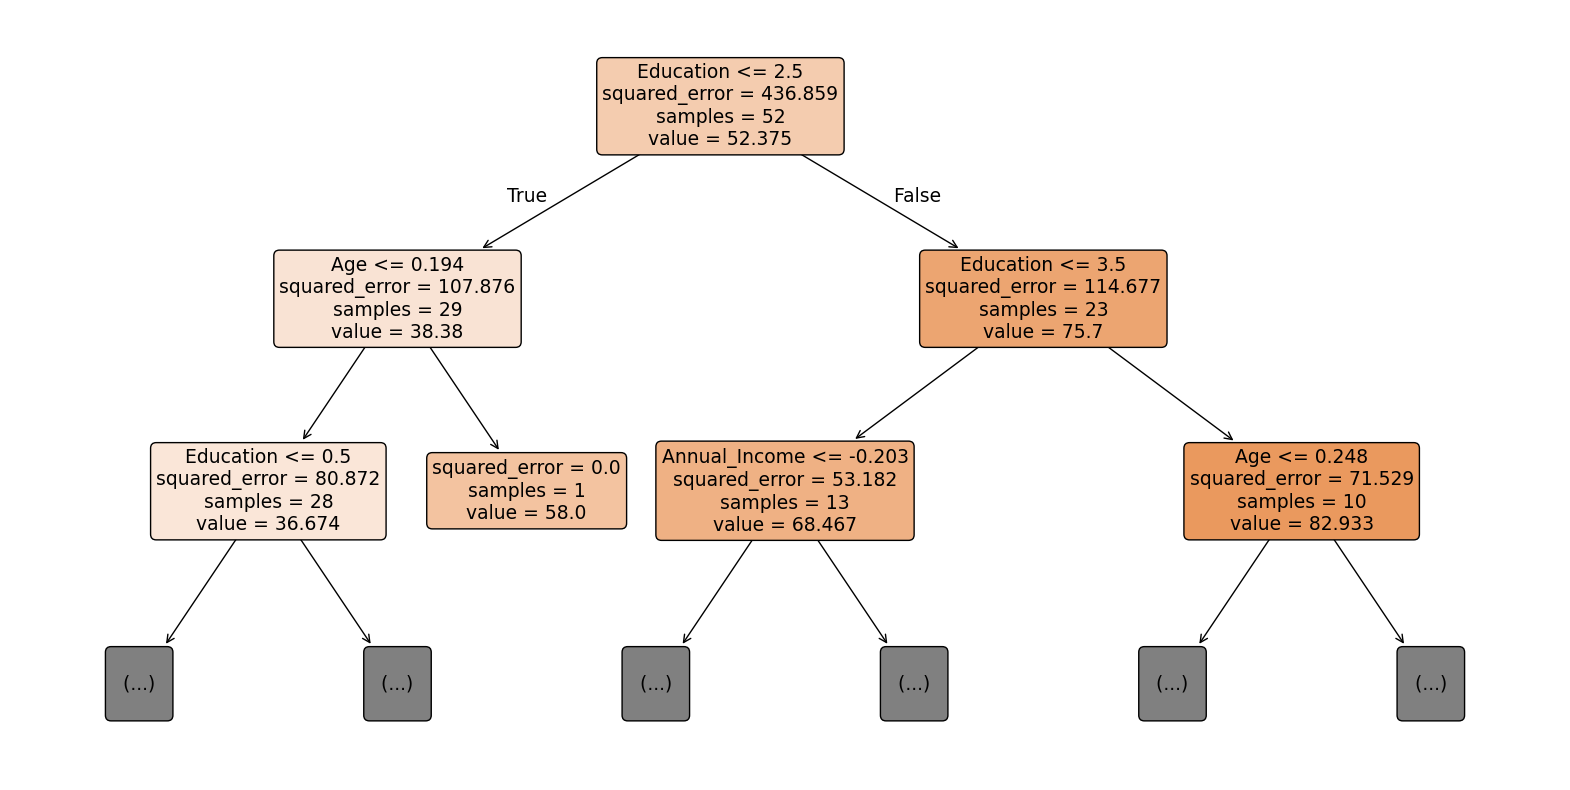

In [135]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(best_model.estimators_[0], filled=True, feature_names=feature_names, max_depth = 2, rounded=True)
plt.show()

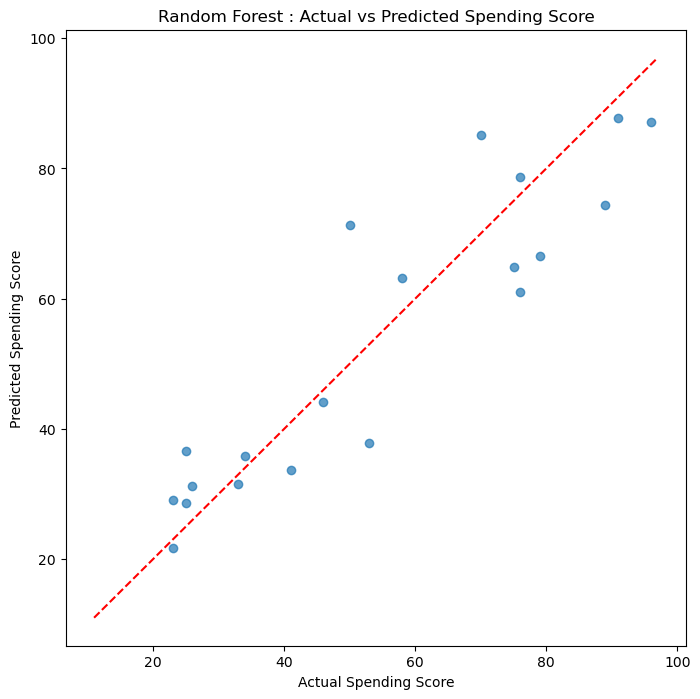

In [136]:
# predict values
y_pred = pipeline.predict(X_test)

plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Spending Score')
plt.ylabel('Predicted Spending Score')
plt.title('Random Forest : Actual vs Predicted Spending Score')
plt.show()

In [139]:
# EDA with data set

df.columns.tolist()

['Customer_ID',
 'Age',
 'Annual_Income',
 'Gender',
 'City',
 'Education',
 'Spending_Score']

/var/folders/jn/k87rrm694dq263mh4gqmfd080000gn/T/ipykernel_18128/4168056929.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Gender', palette='Set2')


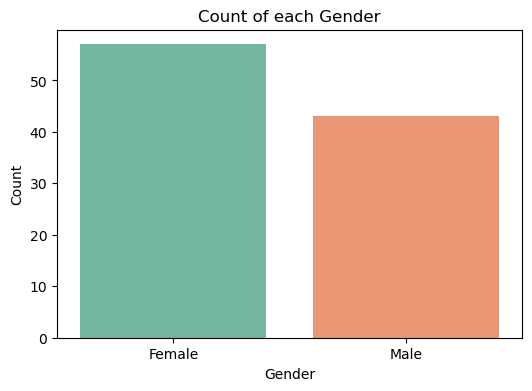

In [140]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Gender', palette='Set2')
plt.title('Count of each Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


<Axes: xlabel='Gender', ylabel='count'>

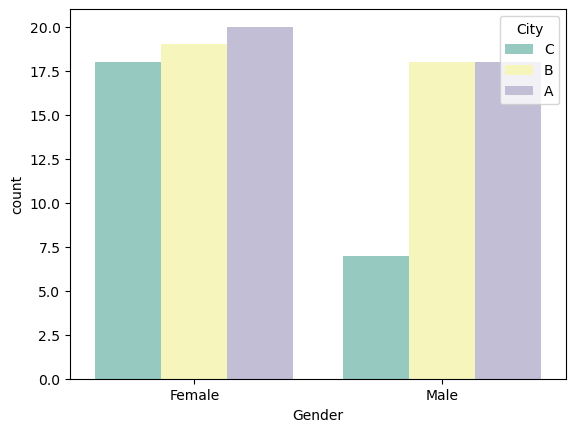

In [141]:
sns.countplot(data=df, x='Gender', hue='City', palette='Set3')


/var/folders/jn/k87rrm694dq263mh4gqmfd080000gn/T/ipykernel_18128/84228955.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='Annual_Income', shade=True, color='blue')


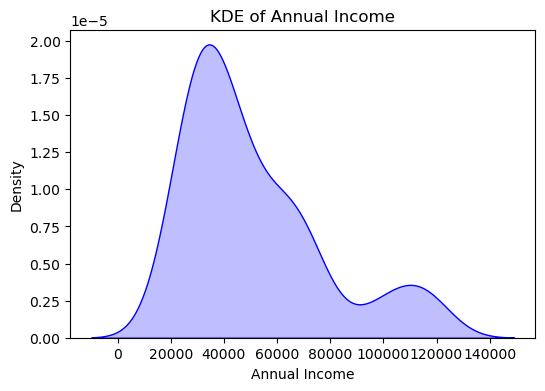

In [142]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='Annual_Income', shade=True, color='blue')
plt.title('KDE of Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Density')
plt.show()


/var/folders/jn/k87rrm694dq263mh4gqmfd080000gn/T/ipykernel_18128/2929943876.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='Annual_Income', hue='Gender', shade=True)


<Axes: xlabel='Annual_Income', ylabel='Density'>

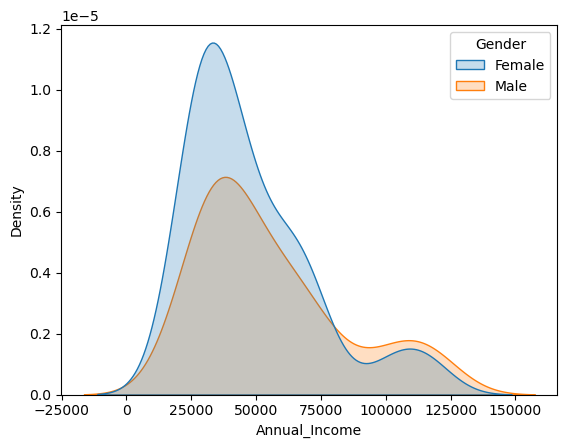

In [143]:
sns.kdeplot(data=df, x='Annual_Income', hue='Gender', shade=True)


/var/folders/jn/k87rrm694dq263mh4gqmfd080000gn/T/ipykernel_18128/1587176929.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gender', y='Annual_Income', palette='Set2')


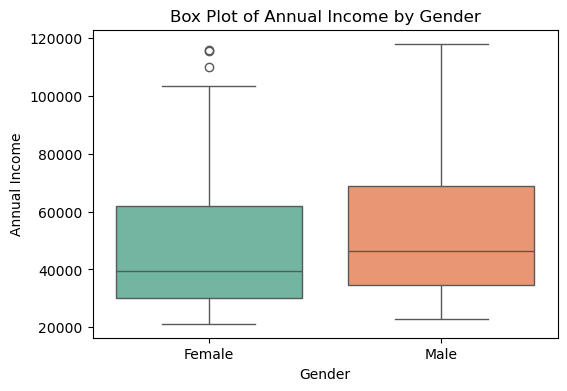

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Gender', y='Annual_Income', palette='Set2')
plt.title('Box Plot of Annual Income by Gender')
plt.xlabel('Gender')
plt.ylabel('Annual Income')
plt.show()


/var/folders/jn/k87rrm694dq263mh4gqmfd080000gn/T/ipykernel_18128/1659665650.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Gender', y='Annual_Income', palette='Set2', inner='quartile')


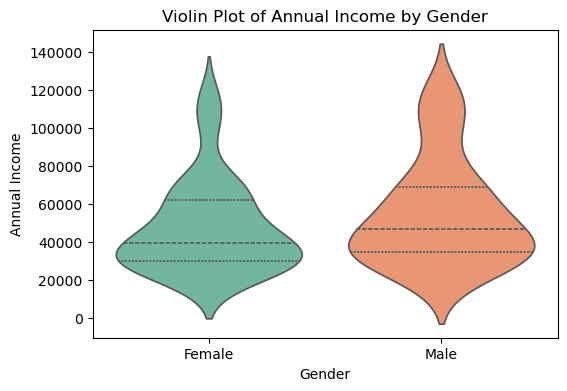

In [145]:
plt.figure(figsize=(6,4))
sns.violinplot(data=df, x='Gender', y='Annual_Income', palette='Set2', inner='quartile')
plt.title('Violin Plot of Annual Income by Gender')
plt.xlabel('Gender')
plt.ylabel('Annual Income')
plt.show()


<Axes: xlabel='Gender', ylabel='Annual_Income'>

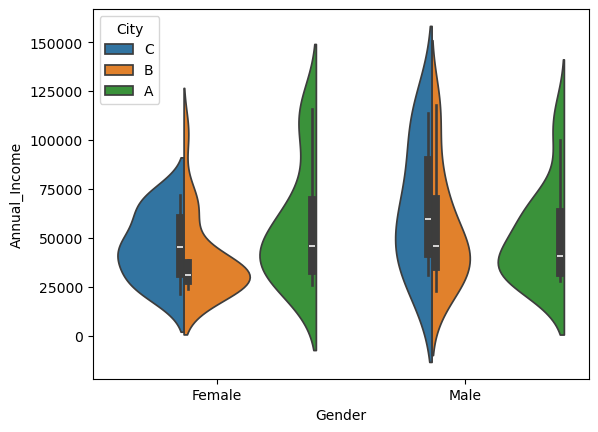

In [146]:
sns.violinplot(data=df, x='Gender', y='Annual_Income', hue='City', split=True)
